In [15]:
# Setup and imports
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set project root
project_root = Path("/home/Plutonium/Documents/BioinfoMidterm")
os.chdir(project_root)
sys.path.insert(0, str(project_root / "scripts"))

print(f"Working directory: {os.getcwd()}")

# Import config module and set population FIRST
import config as cfg
cfg.set_population_config("sea_jpt_cn")

# Now create aliases (pointing to updated config)
PATHS = cfg.PATHS
ML = cfg.ML
POPULATIONS = cfg.POPULATIONS

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)

# Classifiers
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

print("All imports successful!")

Working directory: /home/Plutonium/Documents/BioinfoMidterm
All imports successful!


## Step 1: Load Statistical Results and ML Data

In [16]:
# Load statistical SNP scores from 03b
stats_path = str(PATHS.OUTPUT_DIR / "statistics_snp_scores.csv")
print(f"Loading statistical results from: {stats_path}")

stats_df = pd.read_csv(stats_path)
print(f"Statistical results shape: {stats_df.shape}")
print(f"\nColumns: {list(stats_df.columns)}")

# Load ML data (genotype matrix with population labels)
ml_data_path = str(PATHS.ML_DATA)
print(f"\nLoading ML data from: {ml_data_path}")

df = pd.read_csv(ml_data_path)
print(f"ML data shape: {df.shape}")
print(f"\nPopulation distribution:")
print(df['pop'].value_counts())

Loading statistical results from: 1000genomes/output_sea_jpt_cn/statistics_snp_scores.csv
Statistical results shape: (2518, 21)

Columns: ['snp_id', 'chi2', 'chi2_pvalue', 'g_stat', 'g_pvalue', 'fisher_or', 'fisher_pvalue', 'mutual_information', 'information_gain', 'kl_divergence', 'lr_coef', 'lr_se', 'lr_zscore', 'lr_pvalue', 'lr_pseudo_r2', 'chi2_qvalue', 'chi2_significant_bonf', 'chi2_significant_fdr', 'lr_qvalue', 'lr_significant_bonf', 'lr_significant_fdr']

Loading ML data from: 1000genomes/vcf_sea_jpt_cn/vcf_numeric_transposed_with_population.csv
ML data shape: (504, 2520)

Population distribution:
pop
CN     208
SEA    192
JPT    104
Name: count, dtype: int64


In [17]:
# Prepare features and labels
sample_ids = df['sample']
populations = df['pop']
snp_columns = [c for c in df.columns if c not in ['sample', 'pop']]
X_all = df[snp_columns]
y = populations

print(f"Total samples: {len(df)}")
print(f"Total SNPs in ML data: {len(snp_columns)}")
print(f"\nFirst 5 SNP columns: {snp_columns[:5]}")

Total samples: 504
Total SNPs in ML data: 2518

First 5 SNP columns: ['16:602313', '16:896563', '16:2214387', '16:4519140', '16:5988291']


## Step 2: Identify Consensus SNPs (Significant in All 4 Tests)

In [18]:
# Define significance criteria for each test
# Using FDR-corrected significance for chi2, and top 500 for information-theoretic measures

# Check if significance columns exist
if 'chi2_significant_fdr' in stats_df.columns:
    sig_chi2 = set(stats_df[stats_df['chi2_significant_fdr']]['snp_id'])
else:
    # Fallback: use top 500 by chi2
    sig_chi2 = set(stats_df.nlargest(500, 'chi2')['snp_id'])

sig_mi = set(stats_df.nlargest(500, 'mutual_information')['snp_id'])
sig_ig = set(stats_df.nlargest(500, 'information_gain')['snp_id'])
sig_kl = set(stats_df.nlargest(500, 'kl_divergence')['snp_id'])

print("SNPs Selected by Each Test:")
print("="*60)
print(f"χ² test (FDR significant or top 500): {len(sig_chi2)}")
print(f"Mutual Information (top 500): {len(sig_mi)}")
print(f"Information Gain (top 500): {len(sig_ig)}")
print(f"KL Divergence (top 500): {len(sig_kl)}")

# Count SNPs appearing in multiple tests
all_sig_snps = list(sig_chi2) + list(sig_mi) + list(sig_ig) + list(sig_kl)
snp_counts = Counter(all_sig_snps)

# Get consensus SNPs
snps_in_4 = [s for s, c in snp_counts.items() if c == 4]
snps_in_3 = [s for s, c in snp_counts.items() if c >= 3]
snps_in_2 = [s for s, c in snp_counts.items() if c >= 2]

print(f"\nConsensus SNPs:")
print(f"  Significant in ALL 4 tests: {len(snps_in_4)}")
print(f"  Significant in ≥3 tests: {len(snps_in_3)}")
print(f"  Significant in ≥2 tests: {len(snps_in_2)}")

SNPs Selected by Each Test:
χ² test (FDR significant or top 500): 2518
Mutual Information (top 500): 500
Information Gain (top 500): 500
KL Divergence (top 500): 500

Consensus SNPs:
  Significant in ALL 4 tests: 205
  Significant in ≥3 tests: 500
  Significant in ≥2 tests: 795


In [19]:
# Select consensus SNPs for training
# Use SNPs significant in all 4 tests if enough, otherwise use ≥3

if len(snps_in_4) >= 50:
    consensus_snps = snps_in_4
    consensus_level = "all 4 tests"
elif len(snps_in_3) >= 50:
    consensus_snps = snps_in_3
    consensus_level = "≥3 tests"
else:
    consensus_snps = snps_in_2
    consensus_level = "≥2 tests"

print(f"Using {len(consensus_snps)} SNPs significant in {consensus_level}")

# Filter to SNPs that exist in ML data
available_consensus = [s for s in consensus_snps if s in snp_columns]
print(f"Available in ML data: {len(available_consensus)} SNPs")

# If still not enough, use top SNPs by composite score
if len(available_consensus) < 25:
    print("\nNot enough consensus SNPs. Using top SNPs by composite score...")
    # Create composite score (rank average)
    stats_df['rank_chi2'] = stats_df['chi2'].rank(ascending=False)
    stats_df['rank_mi'] = stats_df['mutual_information'].rank(ascending=False)
    stats_df['rank_ig'] = stats_df['information_gain'].rank(ascending=False)
    stats_df['rank_kl'] = stats_df['kl_divergence'].rank(ascending=False)
    stats_df['composite_rank'] = (stats_df['rank_chi2'] + stats_df['rank_mi'] + 
                                   stats_df['rank_ig'] + stats_df['rank_kl']) / 4
    
    top_composite = stats_df.nsmallest(500, 'composite_rank')['snp_id'].tolist()
    available_consensus = [s for s in top_composite if s in snp_columns]
    print(f"Using top {len(available_consensus)} SNPs by composite rank")

Using 205 SNPs significant in all 4 tests
Available in ML data: 205 SNPs


In [20]:
# Create training data with consensus SNPs
X_consensus = X_all[available_consensus]

print(f"\nConsensus Training Data:")
print(f"  Samples: {X_consensus.shape[0]}")
print(f"  Features (consensus SNPs): {X_consensus.shape[1]}")
print(f"\nFirst 10 consensus SNPs:")
for i, snp in enumerate(available_consensus[:10], 1):
    print(f"  {i}. {snp}")


Consensus Training Data:
  Samples: 504
  Features (consensus SNPs): 205

First 10 consensus SNPs:
  1. 4:155681792
  2. 1:158913641
  3. 2:179308515
  4. 14:105987782
  5. 4:101338449
  6. 9:127101899
  7. 11:112053732
  8. 11:18791211
  9. 1:143543213
  10. 15:71922064


## Step 3: Train Random Forest on Consensus SNPs

In [21]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_consensus, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Encode labels for XGBoost compatibility
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"\nClass encoding: {dict(zip(le.classes_, range(len(le.classes_))))}")

Training set: 403 samples
Test set: 101 samples

Class encoding: {'CN': 0, 'JPT': 1, 'SEA': 2}


In [22]:
# Train Random Forest on consensus SNPs
print("Training Random Forest on consensus SNPs...")

rf_consensus = RandomForestClassifier(
    n_estimators=ML.RF_N_ESTIMATORS,
    max_depth=ML.RF_MAX_DEPTH,
    random_state=42,
    n_jobs=-1
)

rf_consensus.fit(X_train, y_train)

# Evaluate
y_pred_consensus = rf_consensus.predict(X_test)
accuracy_consensus = accuracy_score(y_test, y_pred_consensus)

print(f"\nRandom Forest on Consensus SNPs ({len(available_consensus)} features):")
print(f"  Accuracy: {accuracy_consensus:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_consensus))

Training Random Forest on consensus SNPs...



Random Forest on Consensus SNPs (205 features):
  Accuracy: 0.9208

Classification Report:
              precision    recall  f1-score   support

          CN       0.93      0.88      0.90        42
         JPT       1.00      0.86      0.92        21
         SEA       0.88      1.00      0.94        38

    accuracy                           0.92       101
   macro avg       0.94      0.91      0.92       101
weighted avg       0.93      0.92      0.92       101



In [23]:
# Get feature importances and select top 25
feature_importance = pd.DataFrame({
    'snp': available_consensus,
    'importance': rf_consensus.feature_importances_
}).sort_values('importance', ascending=False)

# Add statistical scores
feature_importance = feature_importance.merge(
    stats_df[['snp_id', 'chi2', 'mutual_information', 'information_gain', 'kl_divergence']],
    left_on='snp', right_on='snp_id', how='left'
).drop('snp_id', axis=1)

print("Top 25 SNPs by Random Forest Importance:")
print("="*80)
display(feature_importance.head(25))

# Get top 25 SNP IDs
TOP_N = ML.TOP_N_FEATURES  # 25
top_25_snps = feature_importance.head(TOP_N)['snp'].tolist()

print(f"\nSelected {TOP_N} top SNPs for final model training")

Top 25 SNPs by Random Forest Importance:


,snp,importance,chi2,mutual_information,information_gain,kl_divergence
0,19:54792079,0.030700,147.862669,0.161159,0.232503,0.557670
1,16:33974960,0.028144,77.153763,0.081076,0.116968,0.356747
2,3:152553769,0.025709,115.513595,0.129657,0.187056,0.563399
3,16:46417894,0.025616,91.093489,0.100690,0.145264,1.529946
4,1:12387655,0.020491,159.962062,0.173566,0.250402,3.868477
5,4:17813761,0.019170,175.081948,0.192157,0.277224,3.878612
6,1:22315762,0.018927,145.506558,0.153762,0.221832,0.659853
7,5:41181491,0.017892,142.028434,0.155135,0.223812,3.279970
8,9:37486004,0.016778,85.923077,0.090649,0.130779,0.290066
9,9:98231346,0.015840,81.994690,0.088283,0.127365,0.280791



Selected 25 top SNPs for final model training


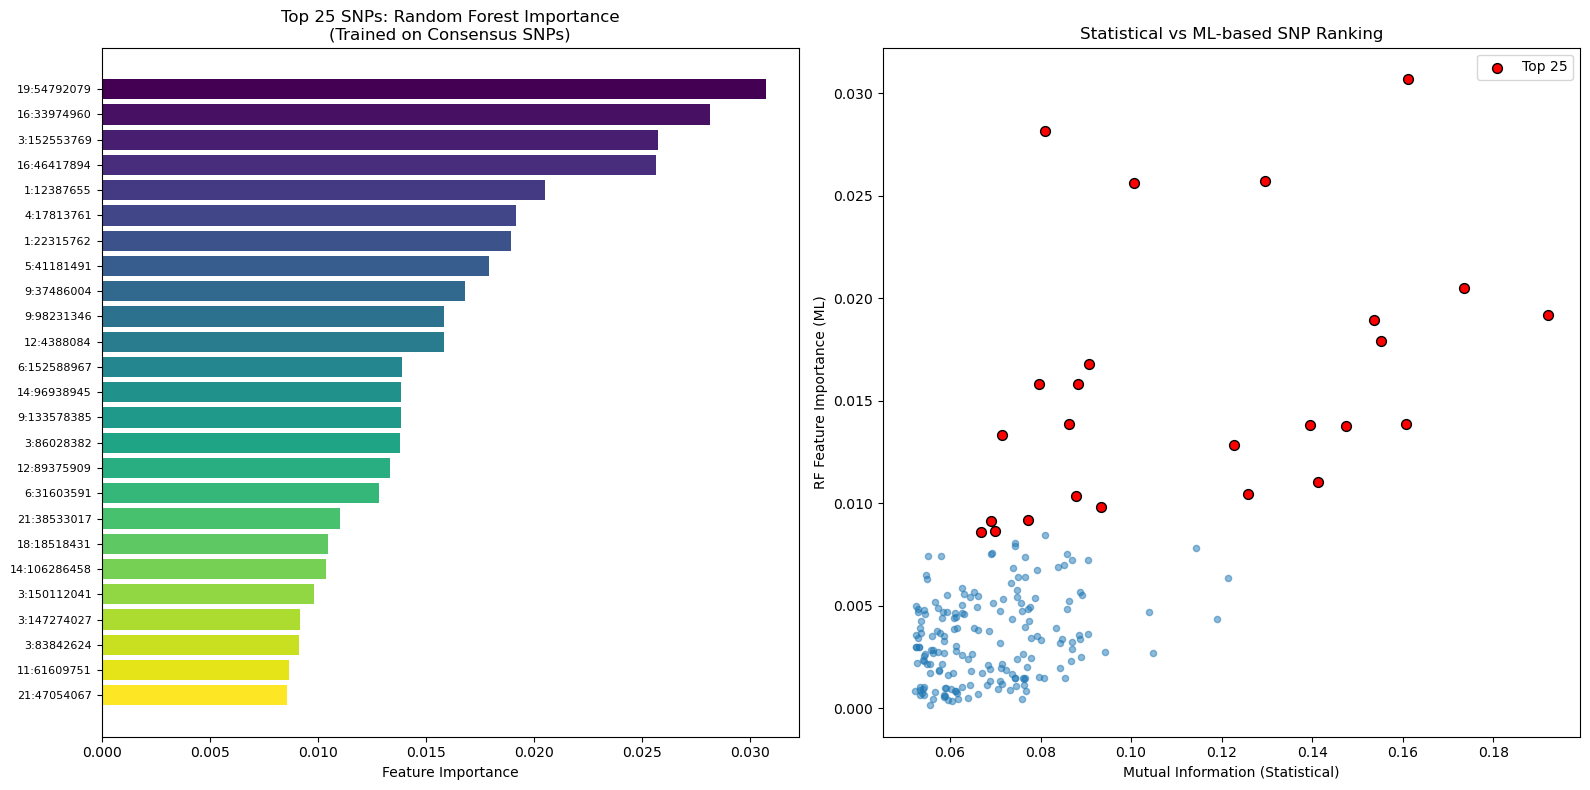

In [24]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Top 25 RF importance
ax = axes[0]
top_25_df = feature_importance.head(25)
colors = plt.cm.viridis(np.linspace(0, 1, 25))
bars = ax.barh(range(25), top_25_df['importance'].values, color=colors)
ax.set_yticks(range(25))
ax.set_yticklabels(top_25_df['snp'].values, fontsize=8)
ax.invert_yaxis()
ax.set_xlabel('Feature Importance')
ax.set_title('Top 25 SNPs: Random Forest Importance\n(Trained on Consensus SNPs)')

# Plot 2: Importance vs MI scatter
ax = axes[1]
ax.scatter(feature_importance['mutual_information'], 
           feature_importance['importance'], alpha=0.5, s=20)
# Highlight top 25
top_25_mask = feature_importance['snp'].isin(top_25_snps)
ax.scatter(feature_importance.loc[top_25_mask, 'mutual_information'],
           feature_importance.loc[top_25_mask, 'importance'],
           color='red', s=50, label='Top 25', edgecolors='black')
ax.set_xlabel('Mutual Information (Statistical)')
ax.set_ylabel('RF Feature Importance (ML)')
ax.set_title('Statistical vs ML-based SNP Ranking')
ax.legend()

plt.tight_layout()
plt.show()

## Step 4: Train Multiple Classifiers on Top 25 SNPs

In [25]:
# Create training data with top 25 SNPs
X_top25 = X_all[top_25_snps]

# Train/test split
X_train_25, X_test_25, y_train_25, y_test_25 = train_test_split(
    X_top25, y, test_size=0.2, random_state=42, stratify=y
)

# Encode labels
y_train_25_enc = le.fit_transform(y_train_25)
y_test_25_enc = le.transform(y_test_25)

# Scale for algorithms that need it
scaler = StandardScaler()
X_train_25_scaled = scaler.fit_transform(X_train_25)
X_test_25_scaled = scaler.transform(X_test_25)

print(f"Top 25 Training Data:")
print(f"  Training: {X_train_25.shape}")
print(f"  Test: {X_test_25.shape}")

Top 25 Training Data:
  Training: (403, 25)
  Test: (101, 25)


In [26]:
# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(
        n_estimators=ML.RF_N_ESTIMATORS, max_depth=ML.RF_MAX_DEPTH, random_state=42, n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=ML.XGB_N_ESTIMATORS, max_depth=ML.XGB_MAX_DEPTH,
        learning_rate=ML.XGB_LEARNING_RATE, random_state=42, n_jobs=-1, verbosity=0
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42, multi_class='multinomial', n_jobs=-1
    ),
    'SVM (RBF)': SVC(
        kernel='rbf', random_state=42, probability=True
    ),
    'SVM (Linear)': SVC(
        kernel='linear', random_state=42, probability=True
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5, n_jobs=-1
    ),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, max_depth=5, random_state=42
    ),
    'AdaBoost': AdaBoostClassifier(
        n_estimators=100, random_state=42, algorithm='SAMME'
    ),
    'MLP Neural Network': MLPClassifier(
        hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True
    )
}

# Try to add TabPFN
try:
    from tabpfn import TabPFNClassifier
    TABPFN_AVAILABLE = True
    print("TabPFN is available and will be included in evaluation")
except ImportError:
    TABPFN_AVAILABLE = False
    print("TabPFN not installed. Install with: pip install tabpfn")

print(f"Training {len(classifiers)} classifiers on top {TOP_N} statistical SNPs...")

TabPFN is available and will be included in evaluation
Training 10 classifiers on top 25 statistical SNPs...


In [27]:
# Train and evaluate all classifiers
results = []

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    
    # Select appropriate data (scaled vs unscaled, encoded vs string labels)
    if 'SVM' in name or 'Logistic' in name or 'KNN' in name or 'MLP' in name:
        X_tr, X_te = X_train_25_scaled, X_test_25_scaled
    else:
        X_tr, X_te = X_train_25.values, X_test_25.values
    
    # Use encoded labels for XGBoost and MLP
    if 'XGBoost' in name or 'MLP' in name:
        y_tr, y_te = y_train_25_enc, y_test_25_enc
    else:
        y_tr, y_te = y_train_25, y_test_25
    
    try:
        # Train
        clf.fit(X_tr, y_tr)
        
        # Predict
        y_pred = clf.predict(X_te)
        
        # Metrics
        acc = accuracy_score(y_te, y_pred)
        
        # Convert back for consistent reporting
        if 'XGBoost' in name or 'MLP' in name:
            y_te_str = le.inverse_transform(y_te)
            y_pred_str = le.inverse_transform(y_pred)
        else:
            y_te_str = y_te
            y_pred_str = y_pred
        
        prec = precision_score(y_te_str, y_pred_str, average='weighted')
        rec = recall_score(y_te_str, y_pred_str, average='weighted')
        f1 = f1_score(y_te_str, y_pred_str, average='weighted')
        
        # Cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(clf, X_tr, y_tr, cv=cv, scoring='accuracy')
        
        results.append({
            'Model': name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1,
            'CV Mean': cv_scores.mean(),
            'CV Std': cv_scores.std()
        })
        
        print(f"  Accuracy: {acc:.4f} | CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        
    except Exception as e:
        print(f"  Error: {e}")
        results.append({
            'Model': name,
            'Accuracy': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'F1-Score': np.nan,
            'CV Mean': np.nan,
            'CV Std': np.nan
        })

# Create results DataFrame
results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
display(results_df)


Training Random Forest...


  Accuracy: 0.8218 | CV: 0.8810 ± 0.0240

Training XGBoost...
  Accuracy: 0.8218 | CV: 0.8835 ± 0.0295

Training Logistic Regression...
  Accuracy: 0.8218 | CV: 0.8908 ± 0.0296

Training SVM (RBF)...
  Accuracy: 0.8416 | CV: 0.9007 ± 0.0222

Training SVM (Linear)...
  Accuracy: 0.8416 | CV: 0.8834 ± 0.0256

Training K-Nearest Neighbors...
  Accuracy: 0.8416 | CV: 0.8313 ± 0.0227

Training Naive Bayes...
  Accuracy: 0.5545 | CV: 0.5136 ± 0.0502

Training Gradient Boosting...
  Accuracy: 0.8020 | CV: 0.8488 ± 0.0381

Training AdaBoost...
  Accuracy: 0.8020 | CV: 0.8536 ± 0.0249

Training MLP Neural Network...
  Accuracy: 0.8416 | CV: 0.8335 ± 0.0603

MODEL COMPARISON RESULTS


,Model,Accuracy,Precision,Recall,F1-Score,CV Mean,CV Std
4,SVM (Linear),0.841584,0.840909,0.841584,0.841140,0.883364,0.025647
3,SVM (RBF),0.841584,0.839347,0.841584,0.839530,0.900741,0.022231
5,K-Nearest Neighbors,0.841584,0.837396,0.841584,0.835814,0.831327,0.022668
9,MLP Neural Network,0.841584,0.842365,0.841584,0.838695,0.833488,0.060345
1,XGBoost,0.821782,0.818262,0.821782,0.819114,0.883488,0.029480
0,Random Forest,0.821782,0.818195,0.821782,0.818581,0.880957,0.023977
2,Logistic Regression,0.821782,0.819633,0.821782,0.819317,0.890833,0.029629
7,Gradient Boosting,0.801980,0.801192,0.801980,0.799549,0.848765,0.038139
8,AdaBoost,0.801980,0.801558,0.801980,0.801032,0.853642,0.024926
6,Naive Bayes,0.554455,0.816899,0.554455,0.516522,0.513642,0.050223


In [28]:
# Train and evaluate TabPFN (if available)
if TABPFN_AVAILABLE:
    print("\nTraining TabPFN...")
    try:
        tabpfn = TabPFNClassifier(device='cpu', n_estimators=4)
        tabpfn.fit(X_train_25.values, y_train_25_enc)
        
        # Predict
        y_pred_tabpfn = tabpfn.predict(X_test_25.values)
        
        # Metrics
        acc = accuracy_score(y_test_25_enc, y_pred_tabpfn)
        y_pred_str = le.inverse_transform(y_pred_tabpfn)
        y_te_str = le.inverse_transform(y_test_25_enc)
        
        prec = precision_score(y_te_str, y_pred_str, average='weighted')
        rec = recall_score(y_te_str, y_pred_str, average='weighted')
        f1 = f1_score(y_te_str, y_pred_str, average='weighted')
        
        # Cross-validation for TabPFN
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = []
        for train_idx, val_idx in cv.split(X_train_25, y_train_25):
            tabpfn_cv = TabPFNClassifier(device='cpu', n_estimators=4)
            X_cv_train = X_train_25.values[train_idx]
            y_cv_train = y_train_25_enc[train_idx]
            X_cv_val = X_train_25.values[val_idx]
            y_cv_val = y_train_25_enc[val_idx]
            tabpfn_cv.fit(X_cv_train, y_cv_train)
            cv_scores.append(accuracy_score(y_cv_val, tabpfn_cv.predict(X_cv_val)))
        
        # Add to results
        tabpfn_result = {
            'Model': 'TabPFN',
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1,
            'CV Mean': np.mean(cv_scores),
            'CV Std': np.std(cv_scores)
        }
        results.append(tabpfn_result)
        
        print(f"  Accuracy: {acc:.4f} | CV: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
        
        # Update results DataFrame
        results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
        
    except Exception as e:
        print(f"  TabPFN Error: {e}")
else:
    print("TabPFN not available, skipping...")


Training TabPFN...
  Accuracy: 0.8119 | CV: 0.9083 ± 0.0214


## Step 5: Visualizations

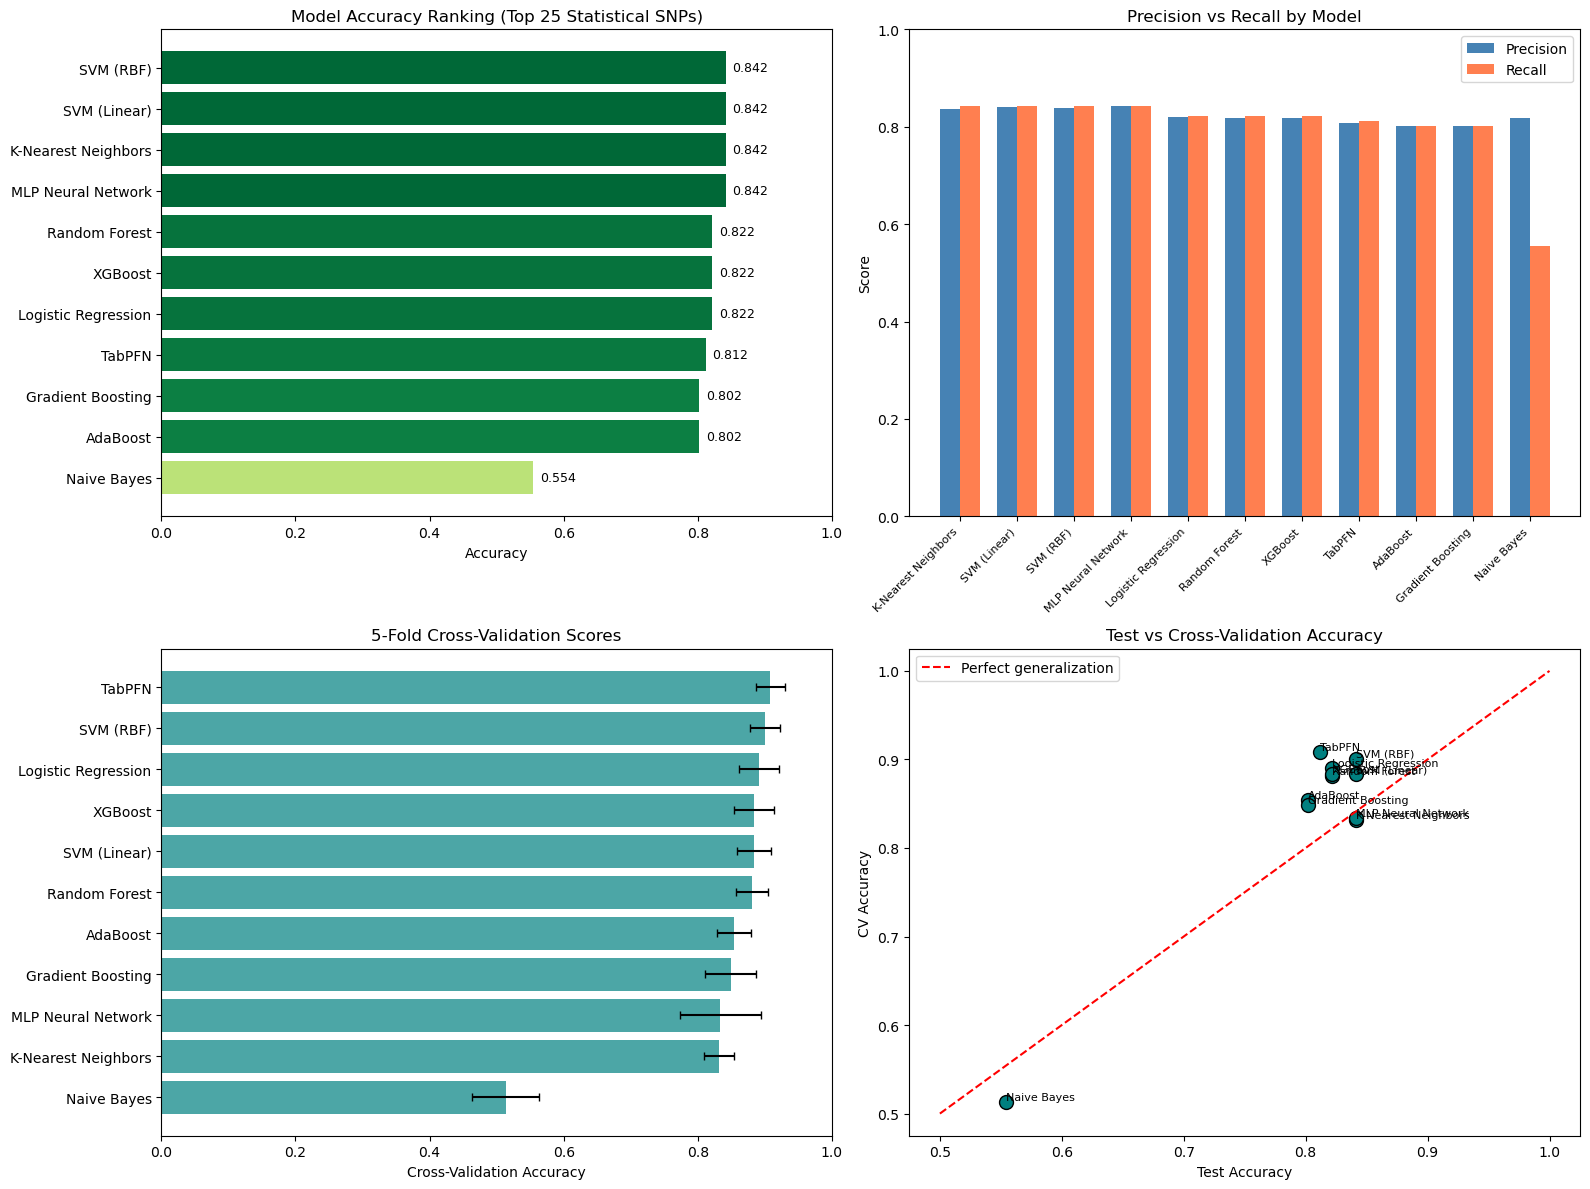

In [29]:
# Model comparison charts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy ranking
ax = axes[0, 0]
sorted_results = results_df.sort_values('Accuracy', ascending=True)
colors = plt.cm.RdYlGn(sorted_results['Accuracy'].values / sorted_results['Accuracy'].max())
bars = ax.barh(sorted_results['Model'], sorted_results['Accuracy'], color=colors)
ax.set_xlabel('Accuracy')
ax.set_title('Model Accuracy Ranking (Top 25 Statistical SNPs)')
ax.set_xlim(0, 1)
for i, (acc, model) in enumerate(zip(sorted_results['Accuracy'], sorted_results['Model'])):
    ax.text(acc + 0.01, i, f'{acc:.3f}', va='center', fontsize=9)

# Plot 2: F1-Score comparison
ax = axes[0, 1]
x = np.arange(len(results_df))
width = 0.35
ax.bar(x - width/2, results_df['Precision'], width, label='Precision', color='steelblue')
ax.bar(x + width/2, results_df['Recall'], width, label='Recall', color='coral')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Score')
ax.set_title('Precision vs Recall by Model')
ax.legend()
ax.set_ylim(0, 1)

# Plot 3: CV Score with error bars
ax = axes[1, 0]
sorted_cv = results_df.sort_values('CV Mean', ascending=True)
ax.barh(sorted_cv['Model'], sorted_cv['CV Mean'], xerr=sorted_cv['CV Std'],
        color='teal', alpha=0.7, capsize=3)
ax.set_xlabel('Cross-Validation Accuracy')
ax.set_title('5-Fold Cross-Validation Scores')
ax.set_xlim(0, 1)

# Plot 4: Accuracy vs CV (generalization check)
ax = axes[1, 1]
ax.scatter(results_df['Accuracy'], results_df['CV Mean'], s=100, c='teal', edgecolors='black')
for i, row in results_df.iterrows():
    ax.annotate(row['Model'], (row['Accuracy'], row['CV Mean']), 
                fontsize=8, ha='left', va='bottom')
ax.plot([0.5, 1], [0.5, 1], 'r--', label='Perfect generalization')
ax.set_xlabel('Test Accuracy')
ax.set_ylabel('CV Accuracy')
ax.set_title('Test vs Cross-Validation Accuracy')
ax.legend()

plt.tight_layout()
plt.show()

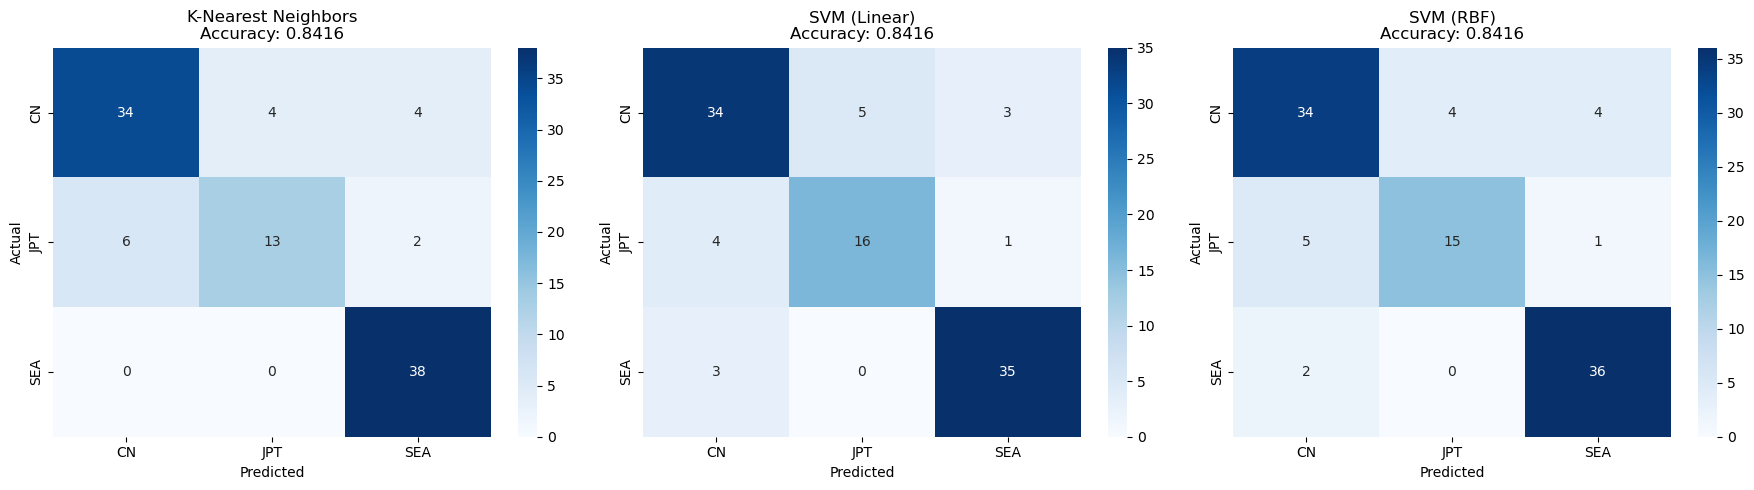

In [30]:
# Confusion matrices for top 3 models
top_3_models = results_df.head(3)['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(top_3_models):
    clf = classifiers[model_name]
    
    # Get appropriate data
    if 'SVM' in model_name or 'Logistic' in model_name or 'KNN' in model_name or 'MLP' in model_name:
        X_te = X_test_25_scaled
    else:
        X_te = X_test_25.values
    
    if 'XGBoost' in model_name or 'MLP' in model_name:
        y_te = y_test_25_enc
        y_pred = clf.predict(X_te)
        y_te = le.inverse_transform(y_te)
        y_pred = le.inverse_transform(y_pred)
    else:
        y_te = y_test_25
        y_pred = clf.predict(X_te)
    
    cm = confusion_matrix(y_te, y_pred, labels=le.classes_)
    
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    acc = accuracy_score(y_te, y_pred)
    ax.set_title(f'{model_name}\nAccuracy: {acc:.4f}')

plt.tight_layout()
plt.show()

## Step 5b: Train Models with Varying SNP Counts (25-50)

Systematically evaluate model performance with different numbers of top SNPs (25, 30, 35, 40, 45, 50) to find the optimal feature set size.

In [31]:
# Define SNP counts to evaluate
snp_counts = [25, 30, 35, 40, 45, 50]

# Define classifiers for this comparison (subset of most performant + TabPFN)
comparison_classifiers = {
    'Random Forest': RandomForestClassifier(
        n_estimators=ML.RF_N_ESTIMATORS, max_depth=ML.RF_MAX_DEPTH, random_state=42, n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=ML.XGB_N_ESTIMATORS, max_depth=ML.XGB_MAX_DEPTH,
        learning_rate=ML.XGB_LEARNING_RATE, random_state=42, n_jobs=-1, verbosity=0
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42, multi_class='multinomial', n_jobs=-1
    ),
    'SVM (RBF)': SVC(
        kernel='rbf', random_state=42, probability=True
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, max_depth=5, random_state=42
    ),
}

print(f"Evaluating models with SNP counts: {snp_counts}")
print(f"Classifiers to compare: {list(comparison_classifiers.keys())}")
if TABPFN_AVAILABLE:
    print("TabPFN will also be included")
print()

Evaluating models with SNP counts: [25, 30, 35, 40, 45, 50]
Classifiers to compare: ['Random Forest', 'XGBoost', 'Logistic Regression', 'SVM (RBF)', 'Gradient Boosting']
TabPFN will also be included



In [32]:
# Train and evaluate models for each SNP count
varying_snp_results = []

for n_snps in snp_counts:
    print(f"\n{'='*60}")
    print(f"Training with TOP {n_snps} SNPs")
    print(f"{'='*60}")
    
    # Get top N SNPs
    top_n_snps = feature_importance.head(n_snps)['snp'].tolist()
    X_topn = X_all[top_n_snps]
    
    # Train/test split (same random state for comparability)
    X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(
        X_topn, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Encode labels
    y_train_n_enc = le.fit_transform(y_train_n)
    y_test_n_enc = le.transform(y_test_n)
    
    # Scale for algorithms that need it
    scaler_n = StandardScaler()
    X_train_n_scaled = scaler_n.fit_transform(X_train_n)
    X_test_n_scaled = scaler_n.transform(X_test_n)
    
    # Train each classifier
    for name, clf in comparison_classifiers.items():
        # Create a fresh instance of the classifier
        if name == 'Random Forest':
            clf = RandomForestClassifier(n_estimators=ML.RF_N_ESTIMATORS, max_depth=ML.RF_MAX_DEPTH, random_state=42, n_jobs=-1)
        elif name == 'XGBoost':
            clf = XGBClassifier(n_estimators=ML.XGB_N_ESTIMATORS, max_depth=ML.XGB_MAX_DEPTH, learning_rate=ML.XGB_LEARNING_RATE, random_state=42, n_jobs=-1, verbosity=0)
        elif name == 'Logistic Regression':
            clf = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', n_jobs=-1)
        elif name == 'SVM (RBF)':
            clf = SVC(kernel='rbf', random_state=42, probability=True)
        elif name == 'Gradient Boosting':
            clf = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
        
        # Select appropriate data
        if 'SVM' in name or 'Logistic' in name:
            X_tr, X_te = X_train_n_scaled, X_test_n_scaled
        else:
            X_tr, X_te = X_train_n.values, X_test_n.values
        
        # Use encoded labels for XGBoost
        if 'XGBoost' in name:
            y_tr, y_te = y_train_n_enc, y_test_n_enc
        else:
            y_tr, y_te = y_train_n, y_test_n
        
        try:
            clf.fit(X_tr, y_tr)
            y_pred = clf.predict(X_te)
            
            acc = accuracy_score(y_te, y_pred)
            
            # Convert labels for consistent scoring
            if 'XGBoost' in name:
                y_te_str = le.inverse_transform(y_te)
                y_pred_str = le.inverse_transform(y_pred)
            else:
                y_te_str = y_te
                y_pred_str = y_pred
            
            f1 = f1_score(y_te_str, y_pred_str, average='weighted')
            
            # Cross-validation
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            cv_scores = cross_val_score(clf, X_tr, y_tr, cv=cv, scoring='accuracy')
            
            varying_snp_results.append({
                'N_SNPs': n_snps,
                'Model': name,
                'Accuracy': acc,
                'F1-Score': f1,
                'CV Mean': cv_scores.mean(),
                'CV Std': cv_scores.std()
            })
            
            print(f"  {name:25} | Acc: {acc:.4f} | F1: {f1:.4f} | CV: {cv_scores.mean():.4f}")
            
        except Exception as e:
            print(f"  {name:25} | Error: {e}")
    
    # Train TabPFN if available
    if TABPFN_AVAILABLE:
        try:
            from tabpfn import TabPFNClassifier
            tabpfn = TabPFNClassifier(device='cpu', n_estimators=4)
            tabpfn.fit(X_train_n.values, y_train_n_enc)
            
            y_pred_tabpfn = tabpfn.predict(X_test_n.values)
            acc = accuracy_score(y_test_n_enc, y_pred_tabpfn)
            
            y_pred_str = le.inverse_transform(y_pred_tabpfn)
            y_te_str = le.inverse_transform(y_test_n_enc)
            f1 = f1_score(y_te_str, y_pred_str, average='weighted')
            
            # CV for TabPFN
            cv_scores = []
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            for train_idx, val_idx in cv.split(X_train_n, y_train_n):
                tabpfn_cv = TabPFNClassifier(device='cpu', n_estimators=4)
                tabpfn_cv.fit(X_train_n.values[train_idx], y_train_n_enc[train_idx])
                cv_scores.append(accuracy_score(y_train_n_enc[val_idx], tabpfn_cv.predict(X_train_n.values[val_idx])))
            
            varying_snp_results.append({
                'N_SNPs': n_snps,
                'Model': 'TabPFN',
                'Accuracy': acc,
                'F1-Score': f1,
                'CV Mean': np.mean(cv_scores),
                'CV Std': np.std(cv_scores)
            })
            
            print(f"  {'TabPFN':25} | Acc: {acc:.4f} | F1: {f1:.4f} | CV: {np.mean(cv_scores):.4f}")
            
        except Exception as e:
            print(f"  TabPFN | Error: {e}")

# Create results DataFrame
varying_results_df = pd.DataFrame(varying_snp_results)
print(f"\n\nTotal experiments: {len(varying_results_df)}")


Training with TOP 25 SNPs
  Random Forest             | Acc: 0.8218 | F1: 0.8186 | CV: 0.8810
  XGBoost                   | Acc: 0.8218 | F1: 0.8191 | CV: 0.8835
  Logistic Regression       | Acc: 0.8218 | F1: 0.8193 | CV: 0.8908
  SVM (RBF)                 | Acc: 0.8416 | F1: 0.8395 | CV: 0.9007
  Gradient Boosting         | Acc: 0.8020 | F1: 0.7995 | CV: 0.8488
  TabPFN                    | Acc: 0.8119 | F1: 0.8080 | CV: 0.9083

Training with TOP 30 SNPs
  Random Forest             | Acc: 0.8911 | F1: 0.8900 | CV: 0.8933
  XGBoost                   | Acc: 0.8713 | F1: 0.8693 | CV: 0.9008
  Logistic Regression       | Acc: 0.8218 | F1: 0.8198 | CV: 0.8983
  SVM (RBF)                 | Acc: 0.9010 | F1: 0.8995 | CV: 0.9131
  Gradient Boosting         | Acc: 0.8614 | F1: 0.8587 | CV: 0.8884
  TabPFN                    | Acc: 0.8812 | F1: 0.8799 | CV: 0.9281

Training with TOP 35 SNPs
  Random Forest             | Acc: 0.9109 | F1: 0.9096 | CV: 0.9182
  XGBoost                   | Acc: 

In [33]:
# Display results table
print("\n" + "="*80)
print("RESULTS: MODEL PERFORMANCE BY SNP COUNT")
print("="*80)

# Pivot table for easy comparison
pivot_accuracy = varying_results_df.pivot(index='Model', columns='N_SNPs', values='Accuracy')
print("\nAccuracy by SNP Count:")
display(pivot_accuracy.round(4))

pivot_f1 = varying_results_df.pivot(index='Model', columns='N_SNPs', values='F1-Score')
print("\nF1-Score by SNP Count:")
display(pivot_f1.round(4))

# Find best configuration
best_config = varying_results_df.loc[varying_results_df['Accuracy'].idxmax()]
print(f"\n★ Best Configuration:")
print(f"  Model: {best_config['Model']}")
print(f"  SNPs: {best_config['N_SNPs']}")
print(f"  Accuracy: {best_config['Accuracy']:.4f}")
print(f"  F1-Score: {best_config['F1-Score']:.4f}")


RESULTS: MODEL PERFORMANCE BY SNP COUNT

Accuracy by SNP Count:


N_SNPs,25,30,35,40,45,50
Model,,,,,,
Gradient Boosting,0.8020,0.8614,0.8614,0.9010,0.9208,0.9307
Logistic Regression,0.8218,0.8218,0.9010,0.9109,0.9208,0.9109
Random Forest,0.8218,0.8911,0.9109,0.9010,0.9208,0.9208
SVM (RBF),0.8416,0.9010,0.9208,0.9307,0.9208,0.9307
TabPFN,0.8119,0.8812,0.8911,0.9307,0.9109,0.9109
XGBoost,0.8218,0.8713,0.9208,0.9109,0.9109,0.9208



F1-Score by SNP Count:


N_SNPs,25,30,35,40,45,50
Model,,,,,,
Gradient Boosting,0.7995,0.8587,0.8594,0.8994,0.9189,0.9298
Logistic Regression,0.8193,0.8198,0.9000,0.9096,0.9204,0.9108
Random Forest,0.8186,0.8900,0.9096,0.8994,0.9202,0.9202
SVM (RBF),0.8395,0.8995,0.9196,0.9300,0.9203,0.9303
TabPFN,0.8080,0.8799,0.8899,0.9300,0.9099,0.9099
XGBoost,0.8191,0.8693,0.9198,0.9089,0.9099,0.9197



★ Best Configuration:
  Model: SVM (RBF)
  SNPs: 40
  Accuracy: 0.9307
  F1-Score: 0.9300


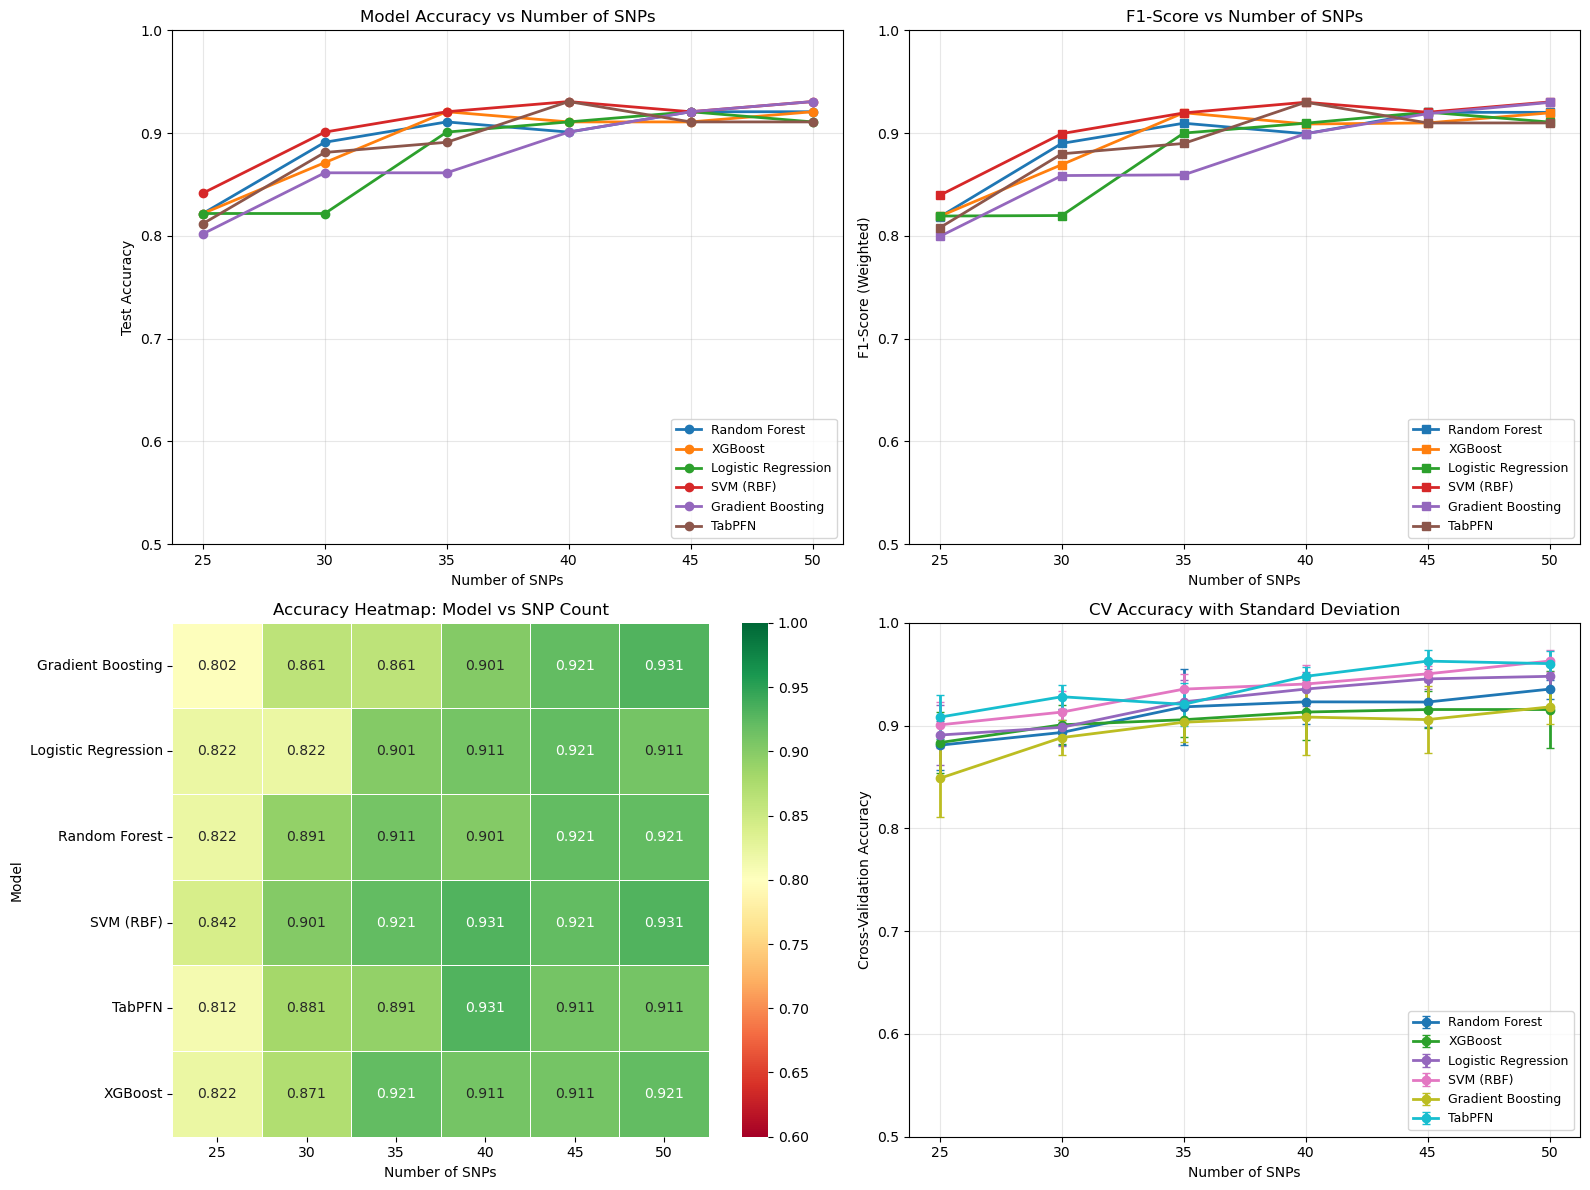


Plot saved to: 1000genomes/output_sea_jpt_cn/varying_snp_performance.png


In [34]:
# Visualization: Performance vs SNP Count
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy vs SNP Count (line plot)
ax = axes[0, 0]
for model in varying_results_df['Model'].unique():
    model_data = varying_results_df[varying_results_df['Model'] == model]
    ax.plot(model_data['N_SNPs'], model_data['Accuracy'], marker='o', label=model, linewidth=2)
ax.set_xlabel('Number of SNPs')
ax.set_ylabel('Test Accuracy')
ax.set_title('Model Accuracy vs Number of SNPs')
ax.legend(loc='lower right', fontsize=9)
ax.set_xticks(snp_counts)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.5, 1.0)

# Plot 2: F1-Score vs SNP Count
ax = axes[0, 1]
for model in varying_results_df['Model'].unique():
    model_data = varying_results_df[varying_results_df['Model'] == model]
    ax.plot(model_data['N_SNPs'], model_data['F1-Score'], marker='s', label=model, linewidth=2)
ax.set_xlabel('Number of SNPs')
ax.set_ylabel('F1-Score (Weighted)')
ax.set_title('F1-Score vs Number of SNPs')
ax.legend(loc='lower right', fontsize=9)
ax.set_xticks(snp_counts)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.5, 1.0)

# Plot 3: Heatmap of Accuracy
ax = axes[1, 0]
heatmap_data = varying_results_df.pivot(index='Model', columns='N_SNPs', values='Accuracy')
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax, 
            vmin=0.6, vmax=1.0, linewidths=0.5)
ax.set_title('Accuracy Heatmap: Model vs SNP Count')
ax.set_xlabel('Number of SNPs')
ax.set_ylabel('Model')

# Plot 4: CV Mean with Error Bars for best model
ax = axes[1, 1]
# Find the best model overall
best_model = varying_results_df.groupby('Model')['Accuracy'].mean().idxmax()
colors = plt.cm.tab10(np.linspace(0, 1, len(varying_results_df['Model'].unique())))
for i, model in enumerate(varying_results_df['Model'].unique()):
    model_data = varying_results_df[varying_results_df['Model'] == model]
    ax.errorbar(model_data['N_SNPs'], model_data['CV Mean'], yerr=model_data['CV Std'],
                marker='o', label=model, capsize=3, linewidth=2, color=colors[i])
ax.set_xlabel('Number of SNPs')
ax.set_ylabel('Cross-Validation Accuracy')
ax.set_title('CV Accuracy with Standard Deviation')
ax.legend(loc='lower right', fontsize=9)
ax.set_xticks(snp_counts)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.5, 1.0)

plt.tight_layout()
plt.savefig(str(PATHS.OUTPUT_DIR / "varying_snp_performance.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to: {PATHS.OUTPUT_DIR / 'varying_snp_performance.png'}")

In [35]:
# Save varying SNP results
varying_results_path = str(PATHS.OUTPUT_DIR / "varying_snp_results.csv")
varying_results_df.to_csv(varying_results_path, index=False)
print(f"Varying SNP results saved to: {varying_results_path}")

# Summary statistics by model
print("\n" + "="*70)
print("SUMMARY: AVERAGE PERFORMANCE BY MODEL (across all SNP counts)")
print("="*70)
model_summary = varying_results_df.groupby('Model').agg({
    'Accuracy': ['mean', 'std', 'max'],
    'F1-Score': ['mean', 'max'],
    'CV Mean': ['mean']
}).round(4)
model_summary.columns = ['Acc Mean', 'Acc Std', 'Acc Max', 'F1 Mean', 'F1 Max', 'CV Mean']
model_summary = model_summary.sort_values('Acc Mean', ascending=False)
display(model_summary)

# Summary by SNP count
print("\n" + "="*70)
print("SUMMARY: AVERAGE PERFORMANCE BY SNP COUNT (across all models)")
print("="*70)
snp_summary = varying_results_df.groupby('N_SNPs').agg({
    'Accuracy': ['mean', 'std', 'max'],
    'F1-Score': ['mean', 'max']
}).round(4)
snp_summary.columns = ['Acc Mean', 'Acc Std', 'Acc Max', 'F1 Mean', 'F1 Max']
display(snp_summary)

# Optimal SNP count
optimal_snp_count = snp_summary['Acc Mean'].idxmax()
print(f"\n★ Optimal SNP count (by mean accuracy): {optimal_snp_count}")

Varying SNP results saved to: 1000genomes/output_sea_jpt_cn/varying_snp_results.csv

SUMMARY: AVERAGE PERFORMANCE BY MODEL (across all SNP counts)


,Acc Mean,Acc Std,Acc Max,F1 Mean,F1 Max,CV Mean
Model,,,,,,
SVM (RBF),0.9076,0.0341,0.9307,0.9066,0.9303,0.9338
Random Forest,0.8944,0.0374,0.9208,0.8930,0.9202,0.9123
XGBoost,0.8927,0.0393,0.9208,0.8911,0.9198,0.9058
TabPFN,0.8894,0.0417,0.9307,0.8879,0.9300,0.9380
Logistic Regression,0.8812,0.0464,0.9208,0.8800,0.9204,0.9235
Gradient Boosting,0.8795,0.0479,0.9307,0.8776,0.9298,0.8955



SUMMARY: AVERAGE PERFORMANCE BY SNP COUNT (across all models)


,Acc Mean,Acc Std,Acc Max,F1 Mean,F1 Max
N_SNPs,,,,,
25,0.8201,0.0132,0.8416,0.8173,0.8395
30,0.8713,0.0280,0.9010,0.8695,0.8995
35,0.9010,0.0226,0.9208,0.8997,0.9198
40,0.9142,0.0135,0.9307,0.9129,0.9300
45,0.9175,0.0051,0.9208,0.9166,0.9204
50,0.9208,0.0089,0.9307,0.9201,0.9303



★ Optimal SNP count (by mean accuracy): 50


## Step 6: Compare with FST-based Selection (if available)

In [36]:
# Try to load FST-based top SNPs for comparison
try:
    fst_top_snps_path = str(PATHS.TOP_SNPS_FILE)
    fst_top_snps = pd.read_csv(fst_top_snps_path)['ID'].tolist()[:TOP_N]
    
    print(f"Loaded {len(fst_top_snps)} FST-selected SNPs")
    
    # Check overlap
    overlap = set(top_25_snps) & set(fst_top_snps)
    print(f"\nOverlap between methods:")
    print(f"  Statistical top {TOP_N}: {len(top_25_snps)} SNPs")
    print(f"  FST-based top {TOP_N}: {len(fst_top_snps)} SNPs")
    print(f"  Shared SNPs: {len(overlap)} ({100*len(overlap)/TOP_N:.1f}%)")
    
    if len(overlap) > 0:
        print(f"\nShared SNPs:")
        for snp in list(overlap)[:10]:
            print(f"  - {snp}")
        if len(overlap) > 10:
            print(f"  ... and {len(overlap) - 10} more")
            
except Exception as e:
    print(f"FST comparison not available: {e}")
    print("Run 03_fst_and_pca.ipynb first to generate FST-selected SNPs.")

FST comparison not available: 'ID'
Run 03_fst_and_pca.ipynb first to generate FST-selected SNPs.


## Step 7: Save Results

In [37]:
# Save model comparison results
output_dir = PATHS.OUTPUT_DIR

# Save results table
results_path = str(output_dir / "statistical_ml_results.csv")
results_df.to_csv(results_path, index=False)
print(f"Model results saved to: {results_path}")

# Save top 25 SNPs with importance
top25_path = str(output_dir / "statistical_top25_snps.csv")
feature_importance.head(TOP_N).to_csv(top25_path, index=False)
print(f"Top 25 SNPs saved to: {top25_path}")

# Save top 25 SNP IDs for external use
top25_ids_path = str(output_dir / "statistical_top25_snp_ids.txt")
with open(top25_ids_path, 'w') as f:
    for snp in top_25_snps:
        f.write(f"{snp}\n")
print(f"Top 25 SNP IDs saved to: {top25_ids_path}")

# Save report
report_path = str(project_root / "reports" / "statistical_ml_report.txt")
with open(report_path, 'w') as f:
    f.write("="*70 + "\n")
    f.write("ML TRAINING ON STATISTICALLY-SELECTED SNPs\n")
    f.write("="*70 + "\n\n")
    
    f.write(f"Dataset:\n")
    f.write(f"  Samples: {len(df)}\n")
    f.write(f"  Populations: {list(y.unique())}\n")
    f.write(f"  Consensus SNPs: {len(available_consensus)}\n")
    f.write(f"  Top SNPs used: {TOP_N}\n\n")
    
    f.write(f"Model Results (Top 25 SNPs):\n")
    f.write("-"*70 + "\n")
    for _, row in results_df.iterrows():
        f.write(f"  {row['Model']:25} | Acc: {row['Accuracy']:.4f} | F1: {row['F1-Score']:.4f} | CV: {row['CV Mean']:.4f}\n")
    
    f.write(f"\nBest Model: {results_df.iloc[0]['Model']}\n")
    f.write(f"  Accuracy: {results_df.iloc[0]['Accuracy']:.4f}\n")
    f.write(f"  F1-Score: {results_df.iloc[0]['F1-Score']:.4f}\n")

print(f"Report saved to: {report_path}")

Model results saved to: 1000genomes/output_sea_jpt_cn/statistical_ml_results.csv
Top 25 SNPs saved to: 1000genomes/output_sea_jpt_cn/statistical_top25_snps.csv
Top 25 SNP IDs saved to: 1000genomes/output_sea_jpt_cn/statistical_top25_snp_ids.txt
Report saved to: /home/Plutonium/Documents/BioinfoMidterm/reports/statistical_ml_report.txt


In [38]:
# Final Summary
print("="*70)
print("STATISTICAL SNP ML TRAINING SUMMARY")
print("="*70)

print(f"\nDataset:")
print(f"  Samples: {len(df)}")
print(f"  Populations: {list(y.unique())}")

print(f"\nSNP Selection:")
print(f"  Consensus SNPs (from 03b): {len(available_consensus)}")
print(f"  Top SNPs for final training: {TOP_N}")

print(f"\nBest Performing Models:")
for i, row in results_df.head(3).iterrows():
    print(f"  {i+1}. {row['Model']}: {row['Accuracy']:.4f} accuracy")

print(f"\nTop 5 SNPs by Importance:")
for i, row in feature_importance.head(5).iterrows():
    print(f"  {i+1}. {row['snp']} (importance: {row['importance']:.4f}, MI: {row['mutual_information']:.4f})")

print(f"\nOutput Files:")
print(f"  - statistical_ml_results.csv")
print(f"  - statistical_top25_snps.csv")
print(f"  - statistical_top25_snp_ids.txt")
print(f"  - reports/statistical_ml_report.txt")

print(f"\nNext Steps:")
print(f"  - Compare with FST-based results (04_ml_training.ipynb)")
print(f"  - Use consensus SNPs from both methods for final model")
print(f"  - Apply to external validation datasets")

STATISTICAL SNP ML TRAINING SUMMARY

Dataset:
  Samples: 504
  Populations: ['CN', 'SEA', 'JPT']

SNP Selection:
  Consensus SNPs (from 03b): 205
  Top SNPs for final training: 25

Best Performing Models:
  6. K-Nearest Neighbors: 0.8416 accuracy
  5. SVM (Linear): 0.8416 accuracy
  4. SVM (RBF): 0.8416 accuracy

Top 5 SNPs by Importance:
  1. 19:54792079 (importance: 0.0307, MI: 0.1612)
  2. 16:33974960 (importance: 0.0281, MI: 0.0811)
  3. 3:152553769 (importance: 0.0257, MI: 0.1297)
  4. 16:46417894 (importance: 0.0256, MI: 0.1007)
  5. 1:12387655 (importance: 0.0205, MI: 0.1736)

Output Files:
  - statistical_ml_results.csv
  - statistical_top25_snps.csv
  - statistical_top25_snp_ids.txt
  - reports/statistical_ml_report.txt

Next Steps:
  - Compare with FST-based results (04_ml_training.ipynb)
  - Use consensus SNPs from both methods for final model
  - Apply to external validation datasets
